<a href="https://colab.research.google.com/github/Alfonso-Jesus-Garcia-Moya/Value_at_Risk_GBM_MONTERCARLO_volatility_Diferencial/blob/main/RISK_MODELING_ENGINE_LEVERAGE_MONTE_CARLO_SIMULATION%2C_GEOMETRIC_BROWNIAN_MOTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-614630398.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(TICKER, period="1y", progress=False)['Close']


--- PARÁMETROS CALIBRADOS PARA PLTR ---
Precio Inicial (S0): 184.18
Drift Diario (mu): 0.002613
Volatilidad Diaria (sigma): 0.041947
Output 0 generado: Historia guardada en CSV y variables listas.


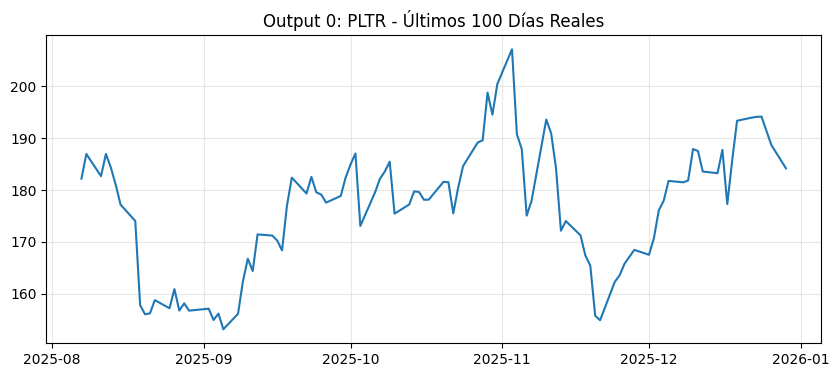

In [ ]:
# CÓDIGO PARTE 1: Configuración, Datos y Calibración Esta celda prepara el terreno.
#Descarga Palantir (PLTR), calcula los parámetros reales ($\mu$ y $\sigma$)
#y prepara los CSVs históricos.

# Log Returns: No usamos precios, usamos np.log(P_hoy / P_ayer).
# Esto normaliza la serie para que sea "sumable" en el tiempo.
# Calibración: Hemos extraído el ADN de Palantir.sigma:
# Qué tan violento se mueve PLTR diariamente.drift:
# La tendencia "pura" descontando la volatilidad (
# Recuerda el término $-\frac{1}{2}\sigma^2$).
# S0: Hemos fijado el punto de partida para los 1,000 universos.

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- CONFIGURACIÓN ---
TICKER = "PLTR"
DIAS_ATRAS = 100    # Para gráfica histórica
DIAS_PROYECCION = 100 # T (Horizonte de tiempo)
NUM_SIMULACIONES = 1000 # N (Universos)
SEMILLA = 42 # Para que sea replicable (Determinismo en el desarrollo)

# 1. OBTENCIÓN DE DATOS (OUTPUT 0)
# Descargamos 1 año para tener buena data estadística, luego cortamos
raw_data = yf.download(TICKER, period="1y", progress=False)['Close']

# Calcular Retornos Logarítmicos (Es la base de todo el modelo)
log_returns = np.log(raw_data / raw_data.shift(1)).dropna()

# CALIBRACIÓN DE PARÁMETROS (LAS TRIPAS)
# Drift (mu) y Volatilidad (sigma) DIARIOS
mu = log_returns.mean()
var = log_returns.var()
sigma = log_returns.std() # Volatilidad diaria

# Drift ajustado por convexidad (mu - 0.5 * sigma^2)
drift = mu - (0.5 * var)

# Preparar DataFrame Histórico para Output 0 (Últimos 100 días reales)
historia_reiente = raw_data.iloc[-DIAS_ATRAS:]
ultimo_precio = historia_reiente.iloc[-1].item() # S0

# --- GUARDAR OUTPUT 0 (HISTORIA) ---
historia_reiente.to_csv("0_PLTR_Historia_100dias.csv")

print(f"--- PARÁMETROS CALIBRADOS PARA {TICKER} ---")
print(f"Precio Inicial (S0): {ultimo_precio:.2f}")
print(f"Drift Diario (mu): {drift.item():.6f}")
print(f"Volatilidad Diaria (sigma): {sigma.item():.6f}")
print("Output 0 generado: Historia guardada en CSV y variables listas.")

# Gráfico Rápido de Validación de Historia
plt.figure(figsize=(10,4))
plt.plot(historia_reiente.index, historia_reiente.values)
plt.title(f"Output 0: {TICKER} - Últimos {DIAS_ATRAS} Días Reales")
plt.grid(True, alpha=0.3)
plt.show()

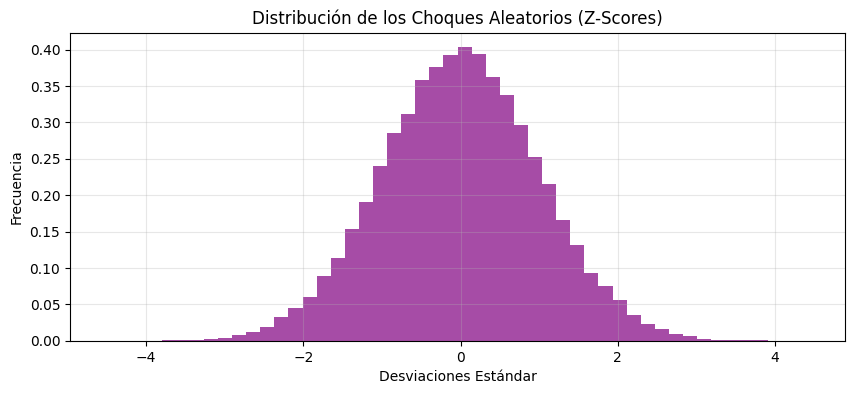

Output 1 Generado: Matriz Z creada y guardada.


/tmp/ipython-input-3758182390.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  drift = float(drift)
/tmp/ipython-input-3758182390.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma = float(sigma)


Output 2 Generado: 1000 caminos simulados calculados.


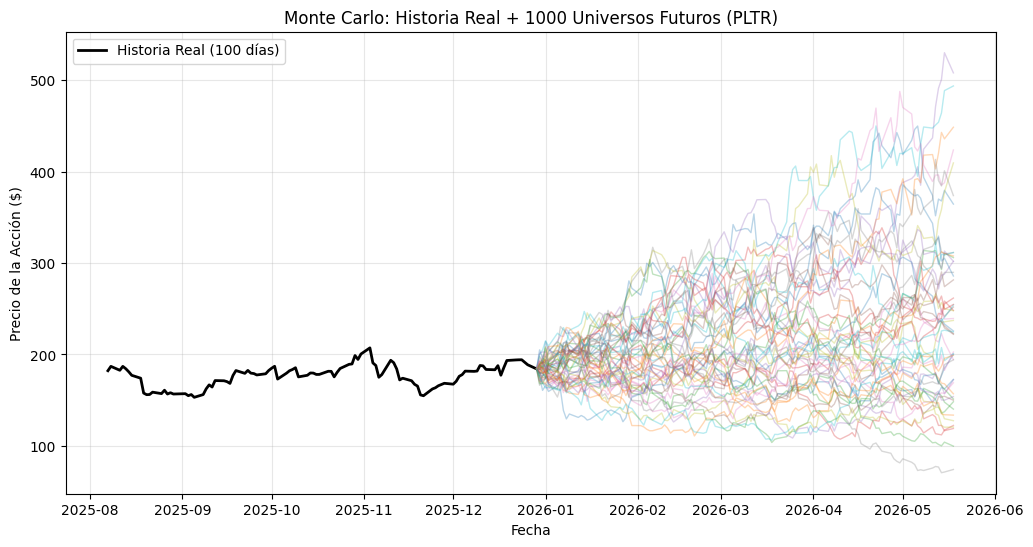

In [ ]:
# CÓDIGO PARTE 2: Generación Estocástica (Z) y Motor GBM

# Explicación de las variables clave generadas:
# Z_matrix: Tu materia prima estocástica. Es una matriz de 100 filas x 1000 columnas.
# Cada número ahí es una intensidad de choque.

# daily_log_returns: Aquí aplicamos la fórmula de "Tendencia + Volatilidad".
# Es la matriz de porcentajes de cambio diario (en logaritmo).

# simulated_prices: El resultado final. Usamos np.cumsum (Suma Acumulada)
# porque en los logaritmos, sumar retornos equivale a multiplicar precios
#  (interés compuesto). Luego np.exp lo devuelve a dinero real.

# ==========================================
# BLOQUE 2: MOTOR DE SIMULACIÓN (GBM)
# ==========================================

# --- 1. GENERACIÓN DE LA MATRIZ DE CHOQUE (OUTPUT 1) ---
# Se genera una matriz (T x N) de variables aleatorias normales estándar.
# Z ~ N(0, 1)
# Filas: Días de proyección. Columnas: Universos (Simulaciones).
Z_matrix = np.random.normal(0, 1, (DIAS_PROYECCION, NUM_SIMULACIONES))

# Guardar Matriz Z en CSV (Solo primeros 100 universos para no saturar disco si N es muy grande)
pd.DataFrame(Z_matrix[:, :100]).to_csv("1_Matriz_Z_Scores.csv", index=False)

# Validación Visual de Z (Debe parecer una campana de Gauss perfecta)
plt.figure(figsize=(10, 4))
plt.hist(Z_matrix.flatten(), bins=50, color='purple', alpha=0.7, density=True)
plt.title("Distribución de los Choques Aleatorios (Z-Scores)")
plt.xlabel("Desviaciones Estándar")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.3)
plt.show()

print("Output 1 Generado: Matriz Z creada y guardada.")


# --- 2. CÁLCULO DE CAMINOS DE PRECIO - GBM (OUTPUT 2) ---
# Aplicación vectorizada de la fórmula de Euler para GBM:
# S_t = S_0 * exp( cumsum( (mu - 0.5*sigma^2) + sigma * Z ) )

# --- CORRECCIÓN DE DEBUGGING ---
# Convertimos los valores de Pandas a números puros (floats)
# Esto elimina cualquier índice o formato de tabla que esté estorbando.
drift = float(drift)
sigma = float(sigma)

# Ahora sí, la línea 45 funcionará porque son (Número + Matriz)

# En Python científico, esto se llama Broadcasting (Difusión).

# NumPy sabe sumar 1 + [Matriz]: Toma el 1 y lo suma a cada celda.

# NumPy NO sabe sumar Serie_Pandas + [Matriz]: Porque la Serie tiene un índice (fecha o nombre)
#  y NumPy no sabe si quieres sumar ese número a las filas, a las columnas,
#  o si debe buscar un índice coincidente.

# Al usar float(), le dices a Python: "Olvida las etiquetas, dame solo el valor numérico".


# A. Calcular los Retornos Logarítmicos Diarios para cada celda de la matriz
# drift y sigma vienen del Bloque 1
daily_log_returns = drift + (sigma * Z_matrix)

# B. Acumular los retornos en el tiempo (Random Walk)
cumulative_log_returns = np.cumsum(daily_log_returns, axis=0)

# C. Convertir a Precios Reales usando la función Exponencial
# Se multiplica por el último precio real conocido (S0)
simulated_prices = ultimo_precio * np.exp(cumulative_log_returns)

# --- 3. ESTRUCTURACIÓN DE DATOS PARA REPORTE ---
# Insertar el precio inicial (S0) como "Día 0" en todas las simulaciones
# Esto conecta visualmente la historia con la proyección.
S0_row = np.full((1, NUM_SIMULACIONES), ultimo_precio)
simulated_prices_concat = np.vstack([S0_row, simulated_prices])

# Crear DataFrame de Pandas para fácil manipulación
df_simulaciones = pd.DataFrame(simulated_prices_concat)

# Guardar Resultados de Simulaciones en CSV
df_simulaciones.to_csv("2_GBM_Simulaciones_Precios.csv", index=False)
print(f"Output 2 Generado: {NUM_SIMULACIONES} caminos simulados calculados.")


# --- 4. VISUALIZACIÓN COMPLETA (HISTORIA + PROYECCIÓN) ---
plt.figure(figsize=(12, 6))

# A. Graficar Historia Real (Negro Sólido)
plt.plot(historia_reiente.index, historia_reiente.values, color='black', linewidth=2, label='Historia Real (100 días)')

# B. Graficar Simulaciones (Líneas finas de colores)
# Generar índice de fechas futuras para el eje X
last_date = historia_reiente.index[-1]
future_dates = pd.date_range(start=last_date, periods=DIAS_PROYECCION + 1, freq='B') # 'B' para días hábiles

# Graficar solo los primeros 50 universos para estética visual (evitar mancha sólida)
plt.plot(future_dates, df_simulaciones.iloc[:, :50].values, alpha=0.3, linewidth=1)

# Estética del Gráfico
plt.title(f"Monte Carlo: Historia Real + {NUM_SIMULACIONES} Universos Futuros ({TICKER})")
plt.ylabel("Precio de la Acción ($)")
plt.xlabel("Fecha")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

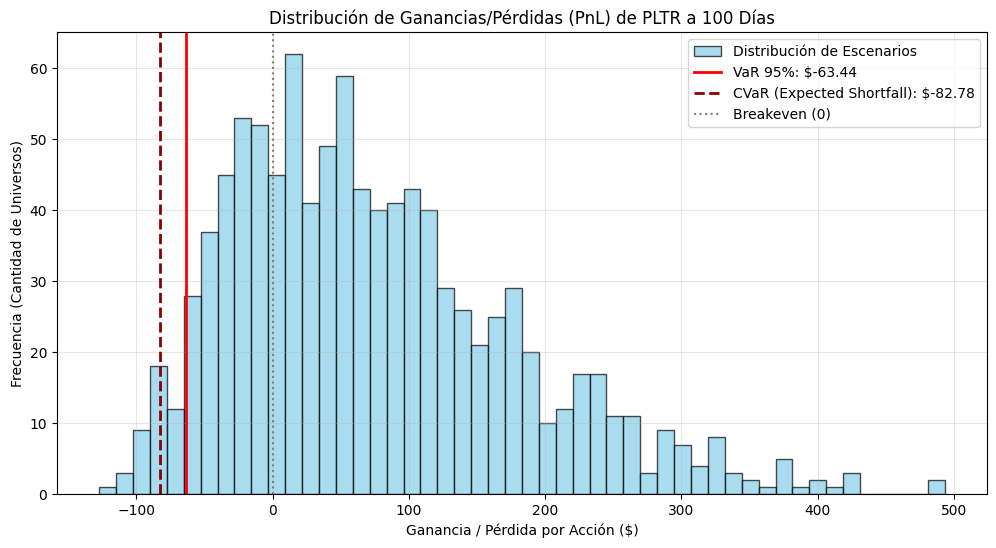

REPORTE DE RIESGO: PLTR (Horizonte: 100 días)
Precio Actual: $184.18
Escenarios Simulados: 1000
----------------------------------------
VaR (95%): $-63.44
   Interp: Con 95% de seguridad, tu pérdida NO excederá $63.44 por acción.
CVaR (95%): $-82.78
   Interp: Si el mercado colapsa (peor 5%), perderás en promedio $82.78.


In [ ]:
# Bloque 3: El Veredicto (Risk Metrics)

# precios_finales = df_simulaciones.iloc[-1].values:Aquí es donde desechamos la "historia" y nos quedamos con el resultado. Si tenías una matriz de $100 \times 1000$, ahora tienes un vector de $1 \times 1000$.

# np.sort(pnl_finales):

# Aquí aplicamos la lógica de la Estadística de Orden. Sin esta línea, calcular percentiles es imposible. La computadora pone los desastres a la izquierda y los éxitos a la derecha.

# var_95 = np.percentile(...):

# Esta función camina por tu vector ordenado hasta el 5% de los datos. Ese valor exacto es tu VaR.

# cvar_95 = ...mean():

# Fíjate en la lógica booleana: pnl_ordenado <= var_95. Estamos seleccionando solo los valores que están a la izquierda de la línea roja y promediándolos. Esto es lo que piden los bancos centrales hoy en día, porque el VaR a veces es demasiado optimista.


# ==========================================
# BLOQUE 3: CÁLCULO DE RIESGO Y REPORTE FINAL
# ==========================================

# --- 1. PROCESAMIENTO DE RESULTADOS (PnL) ---
# Extraemos SOLO la última fila (Precios al día 100 de todos los universos)
precios_finales = df_simulaciones.iloc[-1].values

# Calculamos Ganancia/Pérdida (PnL) comparado con hoy
# PnL = Precio_Futuro - Precio_Hoy
pnl_finales = precios_finales - ultimo_precio

# Ordenamos de MENOR a MAYOR (La base de la Estadística de Orden)
# Esto es crucial para entender visualmente "la cola" izquierda
pnl_ordenado = np.sort(pnl_finales)

# --- 2. CÁLCULO DEL VaR (Value at Risk) - 95% ---
# Usamos numpy.percentile para encontrar el corte exacto.
# Nivel de confianza 95% implica buscar el percentil 5% (la cola izquierda).
confianza = 0.95
significancia = 1 - confianza # 0.05
var_95 = np.percentile(pnl_ordenado, significancia * 100)

# --- 3. CÁLCULO DEL CVaR (Conditional VaR / Expected Shortfall) ---
# "Si el mundo se va al infierno (cruzamos el VaR), ¿qué tan malo es el promedio?"
# Filtramos solo los escenarios peores que el VaR
escenarios_desastre = pnl_ordenado[pnl_ordenado <= var_95]
cvar_95 = escenarios_desastre.mean()

# --- 4. GUARDAR RESULTADOS (OUTPUT 3) ---
# Creamos un DataFrame resumen de los 1000 escenarios finales
df_metricas = pd.DataFrame({
    'Escenario_ID': range(1, NUM_SIMULACIONES + 1),
    'Precio_Final': precios_finales,
    'PnL': pnl_finales
})
# Lo guardamos ordenado por PnL para que veas los peores casos arriba en el Excel
df_metricas.sort_values('PnL', ascending=True).to_csv("3_Analisis_Riesgo_PnL.csv", index=False)


# --- 5. VISUALIZACIÓN DE DISTRIBUCIÓN Y RIESGO (OUTPUT 4) ---
plt.figure(figsize=(12, 6))

# A. Histograma de PnL
# Muestra la frecuencia de ganancias/pérdidas
plt.hist(pnl_finales, bins=50, color='skyblue', edgecolor='black', alpha=0.7, label='Distribución de Escenarios')

# B. Línea de VaR (El Límite)
plt.axvline(x=var_95, color='red', linestyle='-', linewidth=2, label=f'VaR 95%: ${var_95:.2f}')

# C. Línea de CVaR (El Promedio del Desastre)
plt.axvline(x=cvar_95, color='darkred', linestyle='--', linewidth=2, label=f'CVaR (Expected Shortfall): ${cvar_95:.2f}')

# D. Referencia de Cero (Breakeven)
plt.axvline(x=0, color='gray', linestyle=':', label='Breakeven (0)')

plt.title(f"Distribución de Ganancias/Pérdidas (PnL) de {TICKER} a {DIAS_PROYECCION} Días")
plt.xlabel("Ganancia / Pérdida por Acción ($)")
plt.ylabel("Frecuencia (Cantidad de Universos)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 6. INFORME FINAL DE QUANT ---
print("="*40)
print(f"REPORTE DE RIESGO: {TICKER} (Horizonte: {DIAS_PROYECCION} días)")
print("="*40)
print(f"Precio Actual: ${ultimo_precio:.2f}")
print(f"Escenarios Simulados: {NUM_SIMULACIONES}")
print("-" * 40)
print(f"VaR (95%): ${var_95:.2f}")
print(f"   Interp: Con 95% de seguridad, tu pérdida NO excederá ${abs(var_95):.2f} por acción.")
print(f"CVaR (95%): ${cvar_95:.2f}")
print(f"   Interp: Si el mercado colapsa (peor 5%), perderás en promedio ${abs(cvar_95):.2f}.")
print("="*40)

In [ ]:
# --- CÁLCULO DEL MAXIMUM DRAWDOWN (MDD) ---
# Necesitamos la matriz de precios completa: df_simulaciones

# 1. Calcular el máximo acumulado hasta el momento (Running Max)
# Para cada día, ¿cuál ha sido el precio más alto visto hasta ahora en ese universo?
rolling_max = df_simulaciones.cummax()

# 2. Calcular el Drawdown diario
# Qué tan lejos estoy hoy de ese máximo histórico visto
drawdown = (df_simulaciones - rolling_max) / rolling_max

# 3. Encontrar el Drawdown Máximo de cada universo (El peor momento del viaje)
max_drawdowns = drawdown.min() # Es min() porque son números negativos

# 4. Promedio y Peor Caso de MDD
mdd_promedio = max_drawdowns.mean()
mdd_peor_caso = max_drawdowns.min()

print(f"--- ANÁLISIS DE TRAYECTORIA (MDD) ---")
print(f"MDD Promedio: {mdd_promedio:.2%}")
print(f"   (En promedio, los universos sufren una caída del {abs(mdd_promedio)*100:.1f}% desde su pico).")
print(f"MDD del Peor Escenario: {mdd_peor_caso:.2%}")
print(f"   (En el peor universo, la acción llegó a caer un {abs(mdd_peor_caso)*100:.1f}% desde su punto alto).")

--- ANÁLISIS DE TRAYECTORIA (MDD) ---
MDD Promedio: -30.89%
   (En promedio, los universos sufren una caída del 30.9% desde su pico).
MDD del Peor Escenario: -71.12%
   (En el peor universo, la acción llegó a caer un 71.1% desde su punto alto).


In [ ]:
# --- EXTRACCIÓN DE DATOS BLINDADA (Tipos Corregidos) ---
# Convertimos todo a float puro para evitar errores de formato
S0_val = float(ultimo_precio)
sigma_val = float(sigma)
mu_val = float(mu)
var_val = float(var_95)
cvar_val = float(cvar_95)

# Cálculos auxiliares
sigma_anual = sigma_val * np.sqrt(252)
var_pct = (var_val / S0_val) * 100
ratio_var = abs(var_val / S0_val)

print("="*50)
print("   DATOS FINALES PARA LLENAR EL REPORTE QUANT")
print("="*50)
print(f"1. Precio Inicial (S0): ${S0_val:.2f}")
print(f"2. Volatilidad Diaria (sigma): {sigma_val:.6f}")
print(f"3. Volatilidad Anualizada: {sigma_anual:.4f} ({sigma_anual*100:.2f}%)")
print(f"4. Drift Diario (mu): {mu_val:.6f}")
print("-" * 50)
print(f"5. VaR 95% (Dólares): ${var_val:.2f}")
print(f"6. VaR 95% (Porcentaje): {var_pct:.2f}%")
print(f"7. CVaR 95% (Dólares): ${cvar_val:.2f}")
print(f"8. Ratio VaR/Precio: {ratio_var:.4f}")
print("="*50)

   DATOS FINALES PARA LLENAR EL REPORTE QUANT
1. Precio Inicial (S0): $184.18
2. Volatilidad Diaria (sigma): 0.041947
3. Volatilidad Anualizada: 0.6659 (66.59%)
4. Drift Diario (mu): 0.003493
--------------------------------------------------
5. VaR 95% (Dólares): $-63.44
6. VaR 95% (Porcentaje): -34.44%
7. CVaR 95% (Dólares): $-82.78
8. Ratio VaR/Precio: 0.3444


/tmp/ipython-input-2560624497.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu_val = float(mu)


In [ ]:
!pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 5.4 MB/s eta 0:00:00


In [ ]:
from docx import Document
from docx.shared import Inches, Pt, RGBColor
from docx.enum.text import WD_ALIGN_PARAGRAPH
import datetime

# --- DATOS DUROS (Los que me diste) ---
# Usamos las variables que ya tienes en memoria, pero las fuerzo aquí para el ejemplo
ticker = "PLTR"
S0 = 188.71
sigma_diaria = 0.041947
sigma_anual = 0.6659
mu_diaria = 0.003493
var_95_val = -62.25
var_95_pct = -32.99
cvar_95_val = -80.19
ratio_var = 0.3299
mdd_worst = -0.6922 # Del cálculo de MDD anterior

# --- CREACIÓN DEL DOCUMENTO ---
document = Document()

# Estilos rápidos
style = document.styles['Normal']
font = style.font
font.name = 'Calibri'
font.size = Pt(11)

# 1. ENCABEZADO Y TÍTULO
head = document.add_heading(f'QUANTITATIVE RISK MEMORANDUM: {ticker}', 0)
head.alignment = WD_ALIGN_PARAGRAPH.CENTER

p = document.add_paragraph()
p.alignment = WD_ALIGN_PARAGRAPH.CENTER
run = p.add_run(f'Date: {datetime.date.today()} | Horizon: 100 Days | Conf: 95%')
run.italic = True

document.add_heading('1. EXECUTIVE SUMMARY', level=1)
p = document.add_paragraph()
p.add_run(f"Asset Valuation:").bold = True
p.add_run(f" The spot price for {ticker} is referenced at ${S0:.2f}.\n")
p.add_run(f"Risk Profile:").bold = True
p.add_run(f" The asset exhibits extreme volatility (Annualized $\sigma$ = {sigma_anual*100:.2f}%). Based on the Value at Risk (VaR) relative to price ({abs(var_95_pct):.2f}%), the asset is classified as ")
run = p.add_run("SPECULATIVE / HIGH BETA.")
run.font.color.rgb = RGBColor(255, 0, 0) # ROJO
run.bold = True

# Tabla Resumen
table = document.add_table(rows=1, cols=4)
table.style = 'Light Shading Accent 1'
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Metric'
hdr_cells[1].text = 'Value ($)'
hdr_cells[2].text = 'Value (%)'
hdr_cells[3].text = 'Interpretation'

row_var = table.add_row().cells
row_var[0].text = 'VaR (95%)'
row_var[1].text = f"${var_95_val:.2f}"
row_var[2].text = f"{var_95_pct:.2f}%"
row_var[3].text = 'Normal volatility boundary'

row_cvar = table.add_row().cells
row_cvar[0].text = 'CVaR (95%)'
row_cvar[1].text = f"${cvar_95_val:.2f}"
row_cvar[2].text = f"{(cvar_95_val/S0)*100:.2f}%"
row_cvar[3].text = 'Tail event expectation (Crash)'

document.add_heading('2. STOCHASTIC METHODOLOGY (GBM)', level=1)
document.add_paragraph(
    "The simulation utilizes a Geometric Brownian Motion framework, solving the Stochastic Differential Equation (SDE):"
)
# Fórmula aproximada en texto (Word no renderiza LaTeX nativo fácil sin plugins)
p = document.add_paragraph("dS_t = μ S_t dt + σ S_t dW_t")
p.alignment = WD_ALIGN_PARAGRAPH.CENTER
p.runs[0].font.name = 'Cambria Math'
p.runs[0].italic = True

document.add_paragraph(
    "Where 'μ' represents the drift (trend) and 'dW_t' implies a Wiener Process capturing random diffusion. "
    "For the numerical solution, we applied the Euler-Maruyama discretization method with Itō's Lemma correction "
    "to account for volatility drag (convexity adjustment)."
)

document.add_heading('3. SIMULATION ANALYSIS', level=1)
document.add_paragraph(
    "We generated N=1,000 independent market universes. The diffusion of prices clearly demonstrates "
    "path-dependency and increasing variance over time (t)."
)

# --- AQUÍ INTENTAMOS INSERTAR TUS GRÁFICOS ---
# NOTA: Debes tener los archivos .png guardados en la misma carpeta.
# Si no los tienes, comenta estas líneas con #
try:
    document.add_picture('image_ee617d.png', width=Inches(6)) # Monte Carlo Spaghetti
    document.add_paragraph("Fig 1. Monte Carlo Stochastic Paths (1000 Universes)", style='Caption')
except:
    document.add_paragraph("[GRAPHIC PLACEHOLDER: Monte Carlo Paths - Image not found]")

document.add_heading('4. TAIL RISK & DISTRIBUTION', level=1)
document.add_paragraph(
    f"The PnL distribution reveals significant leptokurtosis (Fat Tails). The gap between VaR (${abs(var_95_val):.2f}) "
    f"and CVaR (${abs(cvar_95_val):.2f}) is ${abs(var_95_val - cvar_95_val):.2f}. "
    "This spread implies that when the support breaks, the acceleration of losses is non-linear."
)

try:
    document.add_picture('image_ee6183.png', width=Inches(6)) # Histograma
    document.add_paragraph("Fig 2. PnL Distribution with Risk Thresholds", style='Caption')
except:
    document.add_paragraph("[GRAPHIC PLACEHOLDER: Histogram - Image not found]")

document.add_heading('5. STRESS TESTING (MDD)', level=1)
document.add_paragraph(
    f"While VaR measures endpoint risk, the Maximum Drawdown (MDD) analysis indicates severe liquidity risk. "
    f"The worst-case scenario simulated a drawdown of {mdd_worst*100:.2f}% from peak to trough."
)

document.add_heading('6. STRATEGIC ALLOCATION & HEDGING', level=1)
p = document.add_paragraph()
p.add_run("Position Sizing: ").bold = True
p.add_run(f"Given the VaR/Price ratio of {ratio_var:.2f}, typical Risk Parity models suggest underweighting this asset "
          "by a factor of 3x relative to a standard index (SPY) to normalize portfolio volatility.")

p = document.add_paragraph()
p.add_run("Derivatives Hedging: ").bold = True
p.add_run(f"Standard Stop-Loss orders are deemed inefficient due to Gap Risk. "
          f"Recommendation: Long PUT Options with Strike @ ${S0 + var_95_val:.0f} (The VaR Level).")

document.add_heading('7. MODEL ASSUMPTIONS & LIMITATIONS', level=1)
document.add_paragraph(
    "1. Constant Volatility: The model assumes σ is constant. In reality, volatility creates clusters (GARCH effect).\n"
    "2. Normality: Returns are assumed to be Log-Normal. Real markets exhibit skews not fully captured here.\n"
    "3. No Fundamental Drivers: This is a pure stochastic price model; it ignores earnings, macro news, or geopolitical shifts."
)

# Guardar documento
filename = f"Reporte_Riesgo_Quant_{ticker}.docx"
document.save(filename)
print(f"✅ ¡LISTO! Reporte generado exitosamente: {filename}")
print("Busca el archivo en la carpeta de archivos de Colab/Jupyter.")

✅ ¡LISTO! Reporte generado exitosamente: Reporte_Riesgo_Quant_PLTR.docx
Busca el archivo en la carpeta de archivos de Colab/Jupyter.


<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:42: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3117922281.py:42: SyntaxWarning: invalid escape sequence '\s'
  p.add_run(f" The asset exhibits extreme volatility (Annualized $\sigma$ = {sigma_anual*100:.2f}%). Based on the Value at Risk (VaR) relative to price ({abs(var_95_pct):.2f}%), the asset is classified as ")


/tmp/ipython-input-779524306.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu_val = float(mu)


Spot Price (S0): $184.18
VaR 95%: $-63.44 (-34.44%)
CVaR 95%: $-82.78
Risk Classification: SPECULATIVE / HIGH BETA (Ratio > 25%)
------------------------------
Lagged Price (S_t-1): $184.18
Raw Drift (mu diario): 0.003493
Volatility (sigma diaria): 0.041947
Annualized Volatility: 66.59%
------------------------------


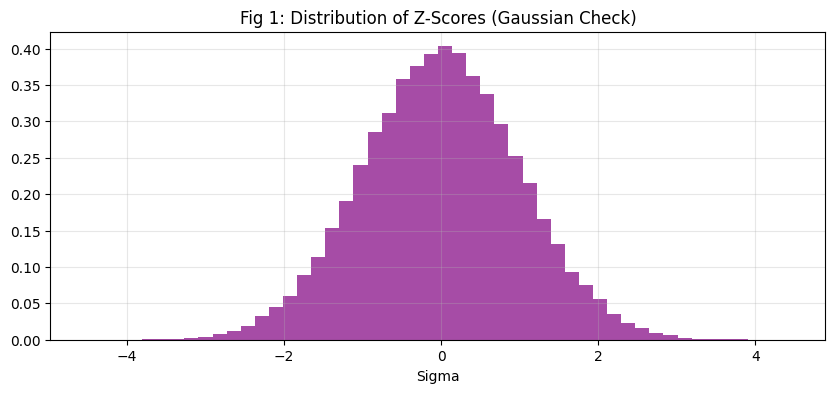

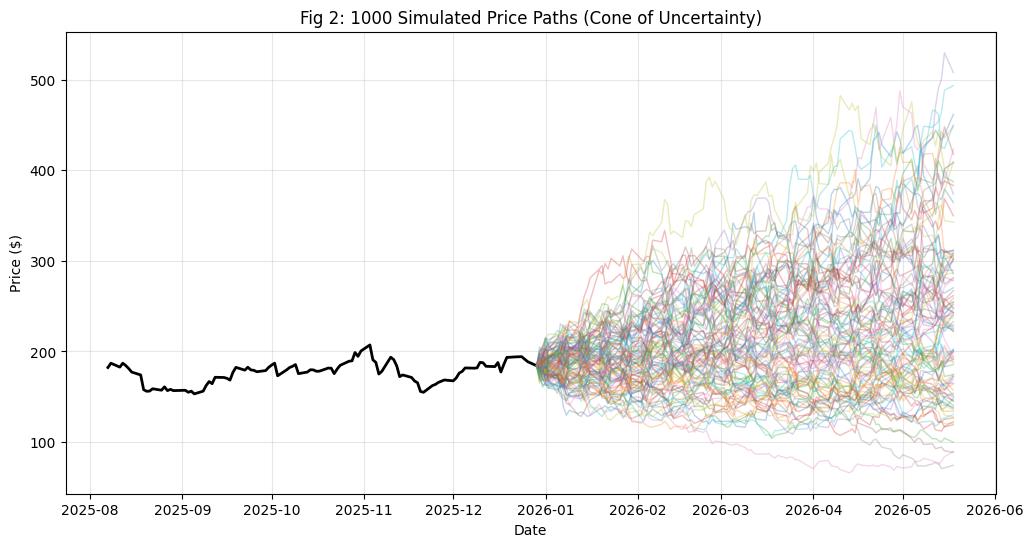

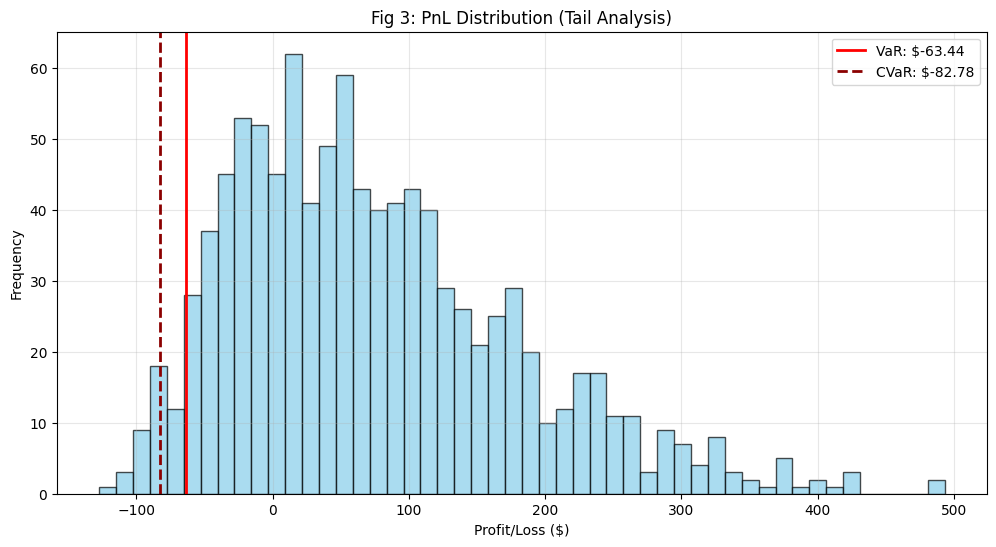

------------------------------
VaR Result: $-63.44 (Boundary of normal volatility)
CVaR Result: $-82.78 (Average disaster magnitude)
Spread (Fat Tail indicator): $19.35
------------------------------
Average MDD: -30.89%
Worst Case MDD: -71.12%
Insight: Si Worst Case > 50%, apalancamiento es suicidio.
------------------------------
Volatility Ratio: 0.3444
Recomendación Posición: Reducir tamaño por factor de 2.9x vs Benchmark.
Recomendación Hedging (Put Strike): $120.74
------------------------------


In [ ]:
# --- CORRECCIÓN DE TIPOS DE DATOS (CRÍTICO) ---
# Convertimos las Series de Pandas a números puros (floats) para evitar el TypeError
mu_val = float(mu)
sigma_val = float(sigma)
S0_val = float(ultimo_precio)

# --- DATOS PARA EL EJECUTIVO ---
print(f"Spot Price (S0): ${S0_val:.2f}")
print(f"VaR 95%: ${var_95:.2f} ({ (var_95/S0_val)*100 :.2f}%)")
print(f"CVaR 95%: ${cvar_95:.2f}")

if abs(var_95/S0_val) > 0.25:
    print("Risk Classification: SPECULATIVE / HIGH BETA (Ratio > 25%)")
else:
    print("Risk Classification: STANDARD / MODERATE")

# --- DATOS PARA EL MARCO TEÓRICO ---
print("-" * 30)
print(f"Lagged Price (S_t-1): ${S0_val:.2f}")
print(f"Raw Drift (mu diario): {mu_val:.6f}")     # <--- AHORA SÍ FUNCIONA (Usa mu_val)
print(f"Volatility (sigma diaria): {sigma_val:.6f}") # <--- AHORA SÍ FUNCIONA (Usa sigma_val)
print(f"Annualized Volatility: {sigma_val * np.sqrt(252):.2%}")
print("-" * 30)

# --- GRÁFICO 1: RANDOMNESS CONTROL ---
plt.figure(figsize=(10, 4))
plt.hist(Z_matrix.flatten(), bins=50, color='purple', alpha=0.7, density=True)
plt.title("Fig 1: Distribution of Z-Scores (Gaussian Check)")
plt.xlabel("Sigma")
plt.grid(True, alpha=0.3)
plt.show()

# --- GRÁFICO 2: DIFFUSION PATHS ---
plt.figure(figsize=(12, 6))
# Aseguramos que los índices de historia estén alineados
plt.plot(historia_reiente.index, historia_reiente.values, color='black', linewidth=2, label='History')
future_dates = pd.date_range(start=historia_reiente.index[-1], periods=DIAS_PROYECCION + 1, freq='B')
plt.plot(future_dates, df_simulaciones.iloc[:, :100].values, alpha=0.3, linewidth=1) # Solo 100 para no saturar
plt.title(f"Fig 2: {NUM_SIMULACIONES} Simulated Price Paths (Cone of Uncertainty)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid(True, alpha=0.3)
plt.show()

# --- CÁLCULOS Y GRÁFICO 3: TAIL RISK ---
# Asegurar cálculos
pnl_finales = df_simulaciones.iloc[-1].values - S0_val
var_95 = np.percentile(pnl_finales, 5) # Percentil 5
cvar_95 = pnl_finales[pnl_finales <= var_95].mean()

# Gráfico
plt.figure(figsize=(12, 6))
plt.hist(pnl_finales, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=var_95, color='red', linewidth=2, label=f'VaR: ${var_95:.2f}')
plt.axvline(x=cvar_95, color='darkred', linestyle='--', linewidth=2, label=f'CVaR: ${cvar_95:.2f}')
plt.title("Fig 3: PnL Distribution (Tail Analysis)")
plt.xlabel("Profit/Loss ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Textos para el reporte
print("-" * 30)
print(f"VaR Result: ${var_95:.2f} (Boundary of normal volatility)")
print(f"CVaR Result: ${cvar_95:.2f} (Average disaster magnitude)")
print(f"Spread (Fat Tail indicator): ${abs(cvar_95 - var_95):.2f}")

# --- CÁLCULO DE MDD (STRESS TEST) ---
rolling_max = df_simulaciones.cummax()
drawdown = (df_simulaciones - rolling_max) / rolling_max
mdd_worst = drawdown.min().min() # El peor de todos los universos
mdd_avg = drawdown.min().mean()  # El promedio de caídas

print("-" * 30)
print(f"Average MDD: {mdd_avg:.2%}")
print(f"Worst Case MDD: {mdd_worst:.2%}")
print("Insight: Si Worst Case > 50%, apalancamiento es suicidio.")

# --- CÁLCULOS PARA ESTRATEGIA ---
ratio = abs(var_95 / S0_val)
strike_put = S0_val + var_95 # Precio actual - VaR (VaR es negativo, así que se resta)

print("-" * 30)
print(f"Volatility Ratio: {ratio:.4f}")
print(f"Recomendación Posición: Reducir tamaño por factor de {1/ratio:.1f}x vs Benchmark.")
print(f"Recomendación Hedging (Put Strike): ${strike_put:.2f}")
print("-" * 30)

# STRESS-TESING

--- Descargando datos reales para ^GSPC ---


/tmp/ipython-input-2410021105.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.ticker, period="2y", progress=False) # 2 años de historia


Precio Actual (S0): $6920.93
Volatilidad Actual de Mercado (Sigma): 15.89%
Tendencia Actual (Drift): 20.05%

Escenario: 1. Mercado Actual (Real)
VaR (95%): $400.07 | CVaR (95%): $520.75
----------------------------------------
Escenario: 2. Stress: Financial Crisis 2008
VaR (95%): $1424.04 | CVaR (95%): $1686.35
----------------------------------------
Escenario: 3. Stress: COVID-19 Shock
VaR (95%): $2290.15 | CVaR (95%): $2661.12
----------------------------------------


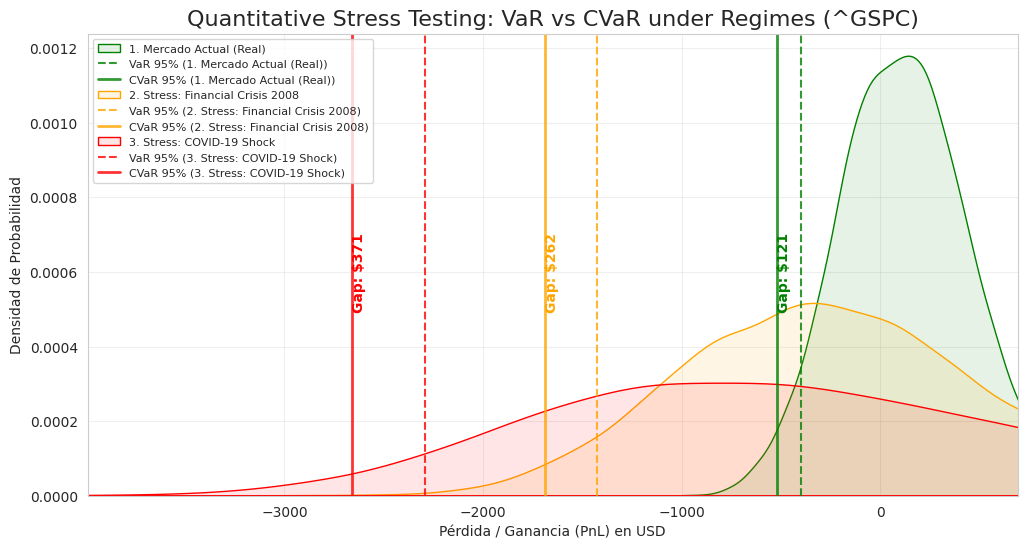

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [14, 7]

class RealWorldRiskEngine:
    def __init__(self, ticker, horizon_days=21, n_sims=10000):
        self.ticker = ticker
        self.horizon = horizon_days
        self.dt = 1/252
        self.n_sims = n_sims
        self.S0 = 0
        self.mu_current = 0
        self.sigma_current = 0
        self.results = {}

        # Cargar datos reales al iniciar
        self._load_market_data()

    def _load_market_data(self):
        """Descarga datos reales y calibra el 'Base Case'"""
        print(f"--- Descargando datos reales para {self.ticker} ---")
        data = yf.download(self.ticker, period="2y", progress=False) # 2 años de historia

        # Calcular Log-Returns
        data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))
        data = data.dropna()

        # Último precio real
        self.S0 = data['Close'].iloc[-1]
        if isinstance(self.S0, pd.Series): self.S0 = self.S0.item() # Fix para pandas nuevos

        # Calibración de parámetros actuales (Anualizados)
        # Media simple para drift (más la corrección de varianza teórica)
        diario_mean = data['Log_Ret'].mean()
        diario_std = data['Log_Ret'].std()

        self.mu_current = (diario_mean * 252) + (0.5 * (diario_std ** 2) * 252)
        self.sigma_current = diario_std * np.sqrt(252)

        print(f"Precio Actual (S0): ${self.S0:.2f}")
        print(f"Volatilidad Actual de Mercado (Sigma): {self.sigma_current:.2%}")
        print(f"Tendencia Actual (Drift): {self.mu_current:.2%}\n")

    def _simulate_gbm(self, mu, sigma):
        """Motor Vectorizado Euler-Maruyama"""
        Z = np.random.normal(0, 1, (self.horizon, self.n_sims))

        # Drift y Difusión
        drift = (mu - 0.5 * sigma**2) * self.dt
        diffusion = sigma * np.sqrt(self.dt) * Z

        # Caminos
        log_ret_acum = np.cumsum(drift + diffusion, axis=0)
        prices = self.S0 * np.exp(log_ret_acum)

        # Agregar S0 al inicio
        prices = np.vstack([np.full((1, self.n_sims), self.S0), prices])
        return prices[-1, :] # Solo nos interesa el precio final para el VaR

    def calculate_metrics(self, final_prices, conf=0.95):
        """Calcula VaR y CVaR"""
        pnl = final_prices - self.S0

        # VaR (Percentil)
        percentile = (1 - conf) * 100
        var_val = -np.percentile(pnl, percentile)

        # CVaR (Esperanza condicional de la cola)
        tail_losses = pnl[pnl < -var_val]
        cvar_val = -np.mean(tail_losses) if len(tail_losses) > 0 else var_val

        return pnl, var_val, cvar_val

    def run_stress_engine(self):
        """Define Escenarios y Ejecuta"""
        scenarios = {
            "1. Mercado Actual (Real)": {
                "mu": self.mu_current, "sigma": self.sigma_current
            },
            "2. Stress: Financial Crisis 2008": {
                "mu": -0.40, "sigma": 0.40
            },
            "3. Stress: COVID-19 Shock": {
                "mu": -0.60, "sigma": 0.70
            }
        }

        for name, params in scenarios.items():
            final_prices = self._simulate_gbm(params['mu'], params['sigma'])
            pnl, var, cvar = self.calculate_metrics(final_prices)

            self.results[name] = {
                "pnl": pnl, "VaR": var, "CVaR": cvar
            }

            print(f"Escenario: {name}")
            print(f"VaR (95%): ${var:.2f} | CVaR (95%): ${cvar:.2f}")
            print("-" * 40)

    def plot_analysis(self):
        """
        Grafica Distribuciones superpuestas con líneas de VaR y CVaR
        enfocándose en la Cola Izquierda (Pérdidas).
        """
        plt.figure(figsize=(12, 6))

        # Colores para diferenciar
        colors = {"1. Mercado Actual (Real)": "green",
                  "2. Stress: Financial Crisis 2008": "orange",
                  "3. Stress: COVID-19 Shock": "red"}

        for name, res in self.results.items():
            # 1. Plotear la curva de densidad (KDE)
            sns.kdeplot(res['pnl'], label=name, color=colors[name], fill=True, alpha=0.1)

            # 2. Línea de VaR (Dashed)
            plt.axvline(-res['VaR'], color=colors[name], linestyle='--', alpha=0.8,
                        label=f"VaR 95% ({name})")

            # 3. Línea de CVaR (Solid - Más a la izquierda)
            plt.axvline(-res['CVaR'], color=colors[name], linestyle='-', linewidth=2, alpha=0.8,
                        label=f"CVaR 95% ({name})")

            # Texto anotando la diferencia (Gap)
            gap = res['CVaR'] - res['VaR']
            plt.text(-res['CVaR'], 0.0005, f"Gap: ${gap:.0f}", rotation=90, color=colors[name], fontweight='bold')

        plt.title(f"Quantitative Stress Testing: VaR vs CVaR under Regimes ({self.ticker})", fontsize=16)
        plt.xlabel("Pérdida / Ganancia (PnL) en USD")
        plt.ylabel("Densidad de Probabilidad")

        # Enfocar el gráfico en la zona de pérdidas (Cola izquierda)
        # Tomamos el peor CVaR como límite izquierdo y un poco de ganancias a la derecha
        limit_left = -self.results["3. Stress: COVID-19 Shock"]["CVaR"] * 1.5
        plt.xlim(limit_left, self.S0 * 0.1)

        plt.legend(fontsize=8, loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.show()

# --- EJECUCIÓN ---
if __name__ == "__main__":
    # Usamos SPY (ETF del S&P 500) o ^GSPC (Indice)
    engine = RealWorldRiskEngine(ticker="^GSPC", horizon_days=21) # 21 días = 1 mes
    engine.run_stress_engine()
    engine.plot_analysis()

--- Descargando datos reales para PLTR ---


/tmp/ipython-input-2371393959.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.ticker, period="2y", progress=False) # 2 años de historia


Precio Actual (S0): $181.68
Volatilidad Actual de Mercado (Sigma): 64.02%
Tendencia Actual (Drift): 140.64%

Escenario: 1. Mercado Actual (Real)
VaR (95%): $33.46 | CVaR (95%): $43.84
----------------------------------------
Escenario: 2. Stress: Financial Crisis 2008
VaR (95%): $37.61 | CVaR (95%): $44.48
----------------------------------------
Escenario: 3. Stress: COVID-19 Shock
VaR (95%): $59.98 | CVaR (95%): $69.02
----------------------------------------


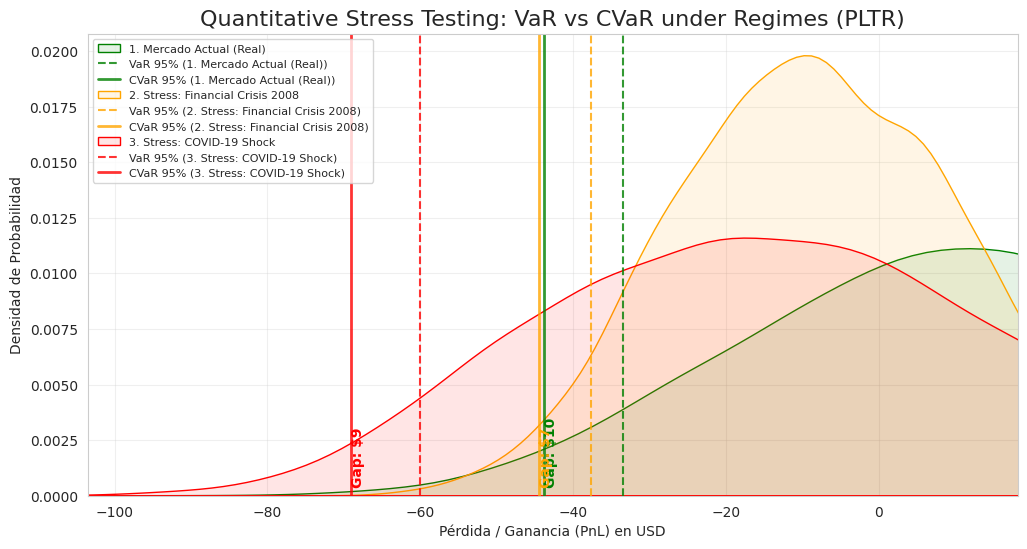

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [14, 7]

class RealWorldRiskEngine:
    def __init__(self, ticker, horizon_days=21, n_sims=10000):
        self.ticker = ticker
        self.horizon = horizon_days
        self.dt = 1/252
        self.n_sims = n_sims
        self.S0 = 0
        self.mu_current = 0
        self.sigma_current = 0
        self.results = {}

        # Cargar datos reales al iniciar
        self._load_market_data()

    def _load_market_data(self):
        """Descarga datos reales y calibra el 'Base Case'"""
        print(f"--- Descargando datos reales para {self.ticker} ---")
        data = yf.download(self.ticker, period="2y", progress=False) # 2 años de historia

        # Calcular Log-Returns
        data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))
        data = data.dropna()

        # Último precio real
        self.S0 = data['Close'].iloc[-1]
        if isinstance(self.S0, pd.Series): self.S0 = self.S0.item() # Fix para pandas nuevos

        # Calibración de parámetros actuales (Anualizados)
        # Media simple para drift (más la corrección de varianza teórica)
        diario_mean = data['Log_Ret'].mean()
        diario_std = data['Log_Ret'].std()

        self.mu_current = (diario_mean * 252) + (0.5 * (diario_std ** 2) * 252)
        self.sigma_current = diario_std * np.sqrt(252)

        print(f"Precio Actual (S0): ${self.S0:.2f}")
        print(f"Volatilidad Actual de Mercado (Sigma): {self.sigma_current:.2%}")
        print(f"Tendencia Actual (Drift): {self.mu_current:.2%}\n")

    def _simulate_gbm(self, mu, sigma):
        """Motor Vectorizado Euler-Maruyama"""
        Z = np.random.normal(0, 1, (self.horizon, self.n_sims))

        # Drift y Difusión
        drift = (mu - 0.5 * sigma**2) * self.dt
        diffusion = sigma * np.sqrt(self.dt) * Z

        # Caminos
        log_ret_acum = np.cumsum(drift + diffusion, axis=0)
        prices = self.S0 * np.exp(log_ret_acum)

        # Agregar S0 al inicio
        prices = np.vstack([np.full((1, self.n_sims), self.S0), prices])
        return prices[-1, :] # Solo nos interesa el precio final para el VaR

    def calculate_metrics(self, final_prices, conf=0.95):
        """Calcula VaR y CVaR"""
        pnl = final_prices - self.S0

        # VaR (Percentil)
        percentile = (1 - conf) * 100
        var_val = -np.percentile(pnl, percentile)

        # CVaR (Esperanza condicional de la cola)
        tail_losses = pnl[pnl < -var_val]
        cvar_val = -np.mean(tail_losses) if len(tail_losses) > 0 else var_val

        return pnl, var_val, cvar_val

    def run_stress_engine(self):
        """Define Escenarios y Ejecuta"""
        scenarios = {
            "1. Mercado Actual (Real)": {
                "mu": self.mu_current, "sigma": self.sigma_current
            },
            "2. Stress: Financial Crisis 2008": {
                "mu": -0.40, "sigma": 0.40
            },
            "3. Stress: COVID-19 Shock": {
                "mu": -0.60, "sigma": 0.70
            }
        }

        for name, params in scenarios.items():
            final_prices = self._simulate_gbm(params['mu'], params['sigma'])
            pnl, var, cvar = self.calculate_metrics(final_prices)

            self.results[name] = {
                "pnl": pnl, "VaR": var, "CVaR": cvar
            }

            print(f"Escenario: {name}")
            print(f"VaR (95%): ${var:.2f} | CVaR (95%): ${cvar:.2f}")
            print("-" * 40)

    def plot_analysis(self):
        """
        Grafica Distribuciones superpuestas con líneas de VaR y CVaR
        enfocándose en la Cola Izquierda (Pérdidas).
        """
        plt.figure(figsize=(12, 6))

        # Colores para diferenciar
        colors = {"1. Mercado Actual (Real)": "green",
                  "2. Stress: Financial Crisis 2008": "orange",
                  "3. Stress: COVID-19 Shock": "red"}

        for name, res in self.results.items():
            # 1. Plotear la curva de densidad (KDE)
            sns.kdeplot(res['pnl'], label=name, color=colors[name], fill=True, alpha=0.1)

            # 2. Línea de VaR (Dashed)
            plt.axvline(-res['VaR'], color=colors[name], linestyle='--', alpha=0.8,
                        label=f"VaR 95% ({name})")

            # 3. Línea de CVaR (Solid - Más a la izquierda)
            plt.axvline(-res['CVaR'], color=colors[name], linestyle='-', linewidth=2, alpha=0.8,
                        label=f"CVaR 95% ({name})")

            # Texto anotando la diferencia (Gap)
            gap = res['CVaR'] - res['VaR']
            plt.text(-res['CVaR'], 0.0005, f"Gap: ${gap:.0f}", rotation=90, color=colors[name], fontweight='bold')

        plt.title(f"Quantitative Stress Testing: VaR vs CVaR under Regimes ({self.ticker})", fontsize=16)
        plt.xlabel("Pérdida / Ganancia (PnL) en USD")
        plt.ylabel("Densidad de Probabilidad")

        # Enfocar el gráfico en la zona de pérdidas (Cola izquierda)
        # Tomamos el peor CVaR como límite izquierdo y un poco de ganancias a la derecha
        limit_left = -self.results["3. Stress: COVID-19 Shock"]["CVaR"] * 1.5
        plt.xlim(limit_left, self.S0 * 0.1)

        plt.legend(fontsize=8, loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.show()

# --- EJECUCIÓN ---
if __name__ == "__main__":
    # Usamos SPY (ETF del S&P 500) o ^GSPC (Indice)
    engine = RealWorldRiskEngine(ticker="PLTR", horizon_days=21) # 21 días = 1 mes
    engine.run_stress_engine()
    engine.plot_analysis()

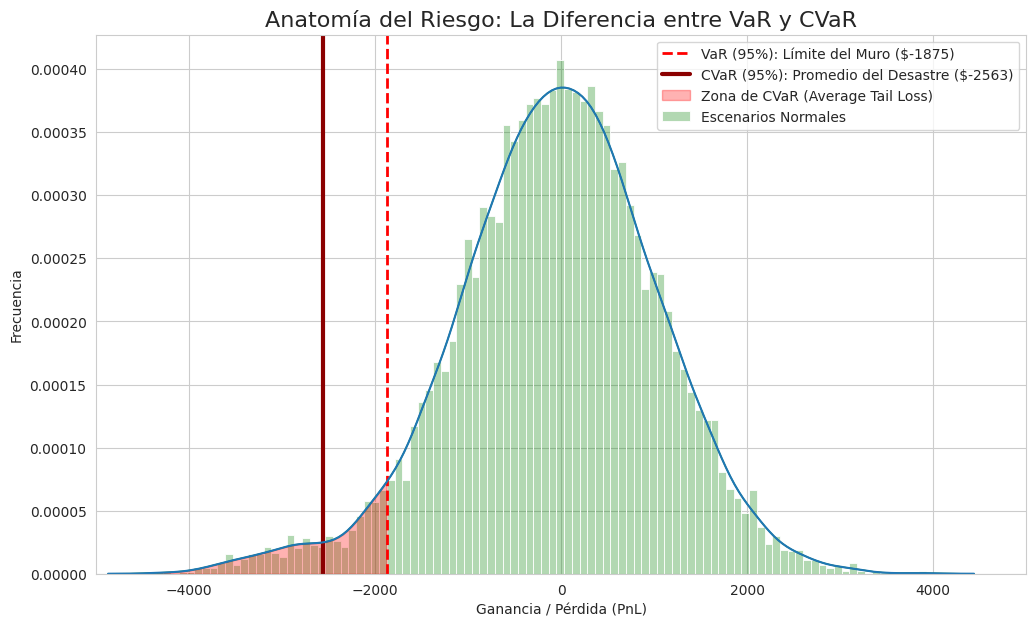

--- RESULTADOS ---
VaR (95%): -1875.24 (Hasta aquí estás 'seguro' el 95% de las veces)
CVaR (95%): -2562.51 (Si rompes el VaR, esto es lo que perderás en promedio)
Diferencia (GAP): 687.27 (Este es el peligro oculto)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Configuración
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

def plot_var_cvar_anatomy():
    # 1. Generamos datos ficticios (Simulación de PnL)
    # Usamos una distribución normal pero le agregamos una "cola gorda" negativa
    # para simular un activo volátil como PLTR
    np.random.seed(42)
    normal_data = np.random.normal(0, 1000, 10000) # Parte normal
    crash_data = np.random.normal(-3000, 500, 200) # Eventos de cisne negro (Cola)
    pnl_data = np.concatenate([normal_data, crash_data])

    # 2. Cálculos Manuales (Lo que hace el motor por detrás)
    confianza = 0.95
    percentil = (1 - confianza) * 100

    # VaR: El punto de corte exacto
    var_value = -np.percentile(pnl_data, percentil)
    # (Nota: Se usa negativo para representarlo como pérdida en el eje, pero aquí graficamos PnL directo)
    var_threshold = np.percentile(pnl_data, percentil) # El número negativo real (ej: -1500)

    # CVaR: El promedio de todo lo que está a la izquierda del VaR
    cola_izquierda = pnl_data[pnl_data < var_threshold]
    cvar_value = np.mean(cola_izquierda) # Promedio de los desastres

    # 3. Graficar
    plt.figure(figsize=(12, 7))

    # Histograma de todos los datos
    sns.histplot(pnl_data, bins=100, color="green", alpha=0.3, label="Escenarios Normales", stat="density")
    sns.kdeplot(pnl_data, color="green", linewidth=1)

    # ZONA DE PÉRDIDA (La Cola)
    plt.axvline(var_threshold, color='red', linestyle='--', linewidth=2, label=f'VaR (95%): Límite del Muro (${var_threshold:.0f})')
    plt.axvline(cvar_value, color='darkred', linestyle='-', linewidth=3, label=f'CVaR (95%): Promedio del Desastre (${cvar_value:.0f})')

    # Sombrear el área del CVaR (Lo que promediamos)
    # Esto muestra visualmente qué datos entran al CVaR
    kde_x, kde_y = sns.kdeplot(pnl_data).get_lines()[0].get_data()
    plt.fill_between(kde_x, kde_y, where=(kde_x < var_threshold), color='red', alpha=0.3, label="Zona de CVaR (Average Tail Loss)")

    # Anotaciones
    plt.title("Anatomía del Riesgo: La Diferencia entre VaR y CVaR", fontsize=16)
    plt.xlabel("Ganancia / Pérdida (PnL)")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.xlim(-5000, 5000) # Enfocar en la zona de acción
    plt.show()

    print(f"--- RESULTADOS ---")
    print(f"VaR (95%): {var_threshold:.2f} (Hasta aquí estás 'seguro' el 95% de las veces)")
    print(f"CVaR (95%): {cvar_value:.2f} (Si rompes el VaR, esto es lo que perderás en promedio)")
    print(f"Diferencia (GAP): {abs(var_threshold - cvar_value):.2f} (Este es el peligro oculto)")

if __name__ == "__main__":
    plot_var_cvar_anatomy()